# Signal Processing using PCA, ICA and NMF

Setting libraries and directory for accessing data

In [ ]:

import numpy as np

from matplotlib.pylab import *
from scipy.io import wavfile
from scipy.signal import stft
from IPython.display import Audio

import matplotlib.pyplot as plt
from scipy.sparse import linalg
import scipy
from numpy import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
directory = "drive/MyDrive/"

# Audio Features


The audio consists of 3 instruments playing in some order. We will process and detect them using **PCA, ICA and NMF**

Import the audio file and visualize the magnitude of the spectrogram of the audio

In [ ]:
# Load audio file
wav_file_path = directory + 'tone.wav'

# Play the audio
Audio(wav_file_path)

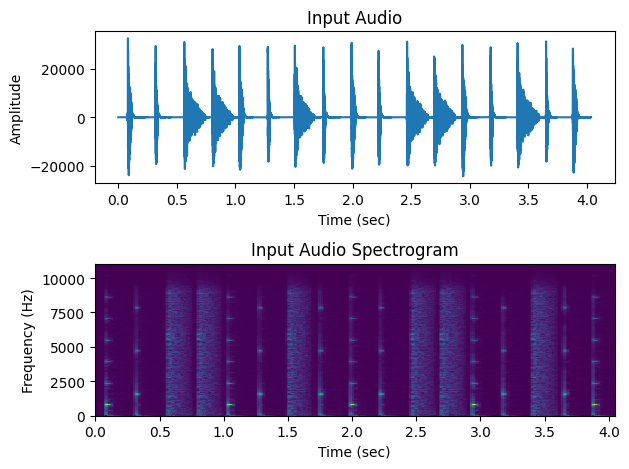

In [ ]:
sample_rate , data = wavfile.read(wav_file_path)

# Plotting audio
subplot(2, 1, 1), plot(arange(0, len(data))/sample_rate, data)
title('Input Audio')
xlabel('Time (sec)'), ylabel('Amplitude')

# Plotting magnitude of the spectrogram
window_size = 1024
overlap = 3/4 * window_size
sample_frequencies, segment_times , Z = stft(data, window='hann', fs = sample_rate, nperseg = window_size, noverlap = overlap)
Z = abs(Z)
subplot(2, 1, 2), pcolormesh(segment_times, sample_frequencies, np.sqrt(Z)), title('Input Audio Spectrogram')
xlabel('Time (sec)'), ylabel('Frequency (Hz)')
tight_layout()



**Observation**: We can see the difference between the three instruments in the spectrogram of the audio. We can relate each beat in the audio to one of the frequency bars in the spectrogram. There are 3 kinds of frequency bar as we see. The first one has 6 peaks in the frequency spectrum, the second one has only 3 peaks and the third one has a totally different thick spread in the frequency. The total audio is composed of these three kinds of beats in a certain fashion.

## Discovering instruments using PCA

In [ ]:
# Perform PCA on the magnitude spectrogram and extract three components.
# The spectrum (frequency) axis will be the input dimensions axis, and each
# time slice of the spectrogram will be a sample. Your PCA components
# should be three “eigenspectra” with as many elements as frequencies.

def pca(data, num_eigen):
    # Remove mean from data before performing PCA
    mean_removed_data = data - mean(data, axis=1, keepdims=True)

    # Get covariance estimate C(Z) = (Z.ZT) /n-1
    C = np.dot(mean_removed_data, np.transpose(mean_removed_data)) / (mean_removed_data.shape[1]-1)

    # Get top 3 PCA covariance eigenvectors/values
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(C, k=num_eigen)

    #descending order of eigenvalues and vectors
    eigenvalues = eigenvalues[::-1]
    eigenvectors = eigenvectors[:,::-1]

    # Resulting transformation
    pcas = np.dot(diag( 1./sqrt(eigenvalues)), np.transpose(eigenvectors))
    weights = np.dot(pcas, mean_removed_data)

    return pcas,weights


In [ ]:
num_eigen = 3
pca_features, pca_weights = pca(Z, num_eigen)

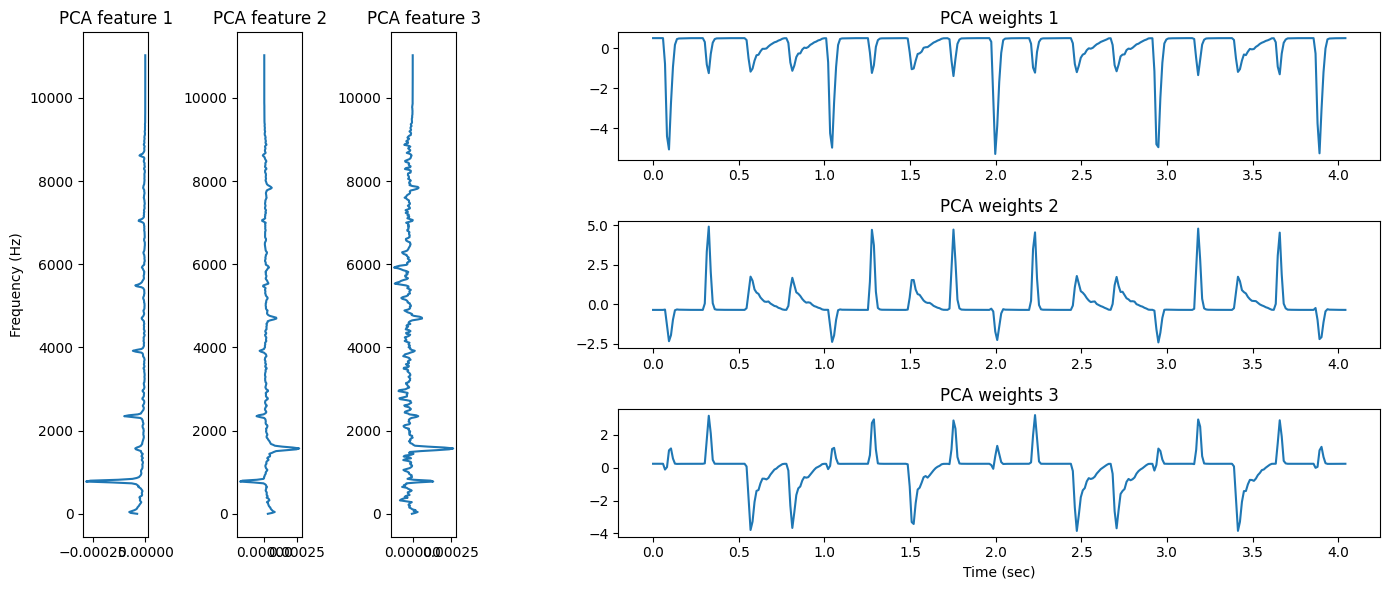

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(14, 6))

# Define subplot positions and create axes for each subplot
ax1 = plt.subplot2grid((1, 9), (0, 0))
ax2 = plt.subplot2grid((1, 9), (0, 1))
ax3 = plt.subplot2grid((1, 9), (0, 2))

ax4 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax5 = plt.subplot2grid((3, 3), (1, 1), colspan=2)
ax6 = plt.subplot2grid((3, 3), (2, 1), colspan=2)

# Plot your data and set titles, labels, etc.
ax1.plot(pca_features[0], sample_frequencies)
ax1.set_title('PCA feature 1')
ax1.set_ylabel('Frequency (Hz)')

ax2.plot(pca_features[1], sample_frequencies)
ax2.set_title('PCA feature 2')

ax3.plot(pca_features[2], sample_frequencies)
ax3.set_title('PCA feature 3')

ax4.plot(segment_times, pca_weights[0])
ax4.set_title('PCA weights 1')

ax5.plot(segment_times, pca_weights[1])
ax5.set_title('PCA weights 2')

ax6.plot(segment_times, pca_weights[2])
ax6.set_title('PCA weights 3')
ax6.set_xlabel('Time (sec)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


**Observation**: In PCA, we see that the first component identified has negative values while teh other two has positive values. Also, while the first one has one peak and other smaller ones on teh same side, the other two features are a mix of low and high tones on either side. There is no specific clue that we can make of from the plots for PCA as it is kind of mixed and match all over the place. But, we can probably interpret the third feature to be of the drum sound as it is more vibrating.

## Discovering instruments using ICA

In [ ]:
# ICA
# ΔW∝(NI−2tanh(y)⋅y⊤)⋅W

def ica(data, num_eigen, max_iterations=500, learning_rate=0.0001):

    num_sources, num_samples = data.shape
    identity_matrix = np.eye(num_sources)
    mixing_matrix = np.eye(num_sources)

    for _ in range(max_iterations):
        # Estimate the independent components
        estimated_sources = np.dot(mixing_matrix,data)

        # Compute the update for the mixing matrix
        gradient = (num_samples * identity_matrix - 2 * np.tanh(estimated_sources) @ estimated_sources.T) @ mixing_matrix
        update = learning_rate * gradient

        # Update the mixing matrix
        mixing_matrix += update

    return mixing_matrix, estimated_sources


In [ ]:
ica_features, ica_weights = ica(pca_weights, num_eigen)
a = np.linalg.pinv(ica_features @ pca_features)

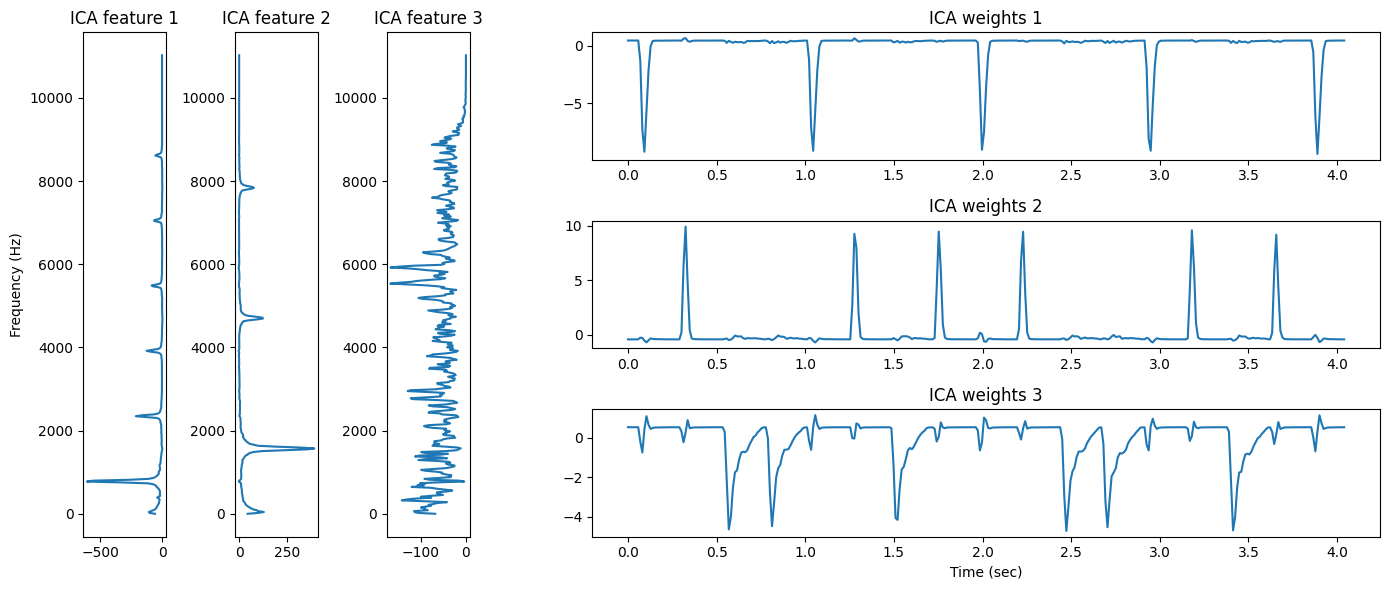

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(14, 6))

# Define subplot positions and create axes for each subplot
ax1 = plt.subplot2grid((1, 9), (0, 0))
ax2 = plt.subplot2grid((1, 9), (0, 1))
ax3 = plt.subplot2grid((1, 9), (0, 2))

ax4 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax5 = plt.subplot2grid((3, 3), (1, 1), colspan=2)
ax6 = plt.subplot2grid((3, 3), (2, 1), colspan=2)

# Plot your data and set titles, labels, etc.
ax1.plot(a[:,0], sample_frequencies)
ax1.set_title('ICA feature 1')
ax1.set_ylabel('Frequency (Hz)')

ax2.plot(a[:,1], sample_frequencies)
ax2.set_title('ICA feature 2')

ax3.plot(a[:,2], sample_frequencies)
ax3.set_title('ICA feature 3')

ax4.plot(segment_times, ica_weights[0])
ax4.set_title('ICA weights 1')

ax5.plot(segment_times, ica_weights[1])
ax5.set_title('ICA weights 2')

ax6.plot(segment_times, ica_weights[2])
ax6.set_title('ICA weights 3')
ax6.set_xlabel('Time (sec)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


**Observation**: Using ICA, we observe a nearly perfect representation of the three instruments. The associated weight vectors offer a compelling interpretation of the input data. The initial weight vector reveals the temporal activation pattern of the low tone that we hear the first in the audio. Similarly, the second and third features detail how the remaining two instruments activate over time with third one representing the drum sound. The sign inversion in the weights aligns with the feature's characteristics. When these two vectors are multiplied, they reconstruct the sound segment corresponding to that particular instrument.


## Discovering instruments using NMF

In [ ]:
# Start with random W
# • estimate new H given W:
# • estimate new W given H:
# • repeat until convergence

def nmf(data, num_eigen, max_iter=100, tolerance=1e-6):

    # Initialize non-negative matrices W and H with random values
    num_samples, num_features = data.shape
    W = np.random.rand(num_samples, num_eigen)
    H = np.random.rand(num_eigen, num_features)

    for _ in range(max_iter):
        # Update matrix H
        numerator_h = np.transpose(W).dot(data)
        denominator_h = np.transpose(W).dot(W).dot(H) + tolerance
        H *= numerator_h / denominator_h

        # Update matrix W
        numerator_w = data.dot(np.transpose(H))
        denominator_w = W.dot(H).dot(np.transpose(H)) + tolerance
        W *= numerator_w / denominator_w

        # Check for convergence
        if np.linalg.norm(data - np.dot(W, H)) < tolerance:
            break

    return W, H


In [ ]:
# Do NMF on the original input data
nmf_features, nmf_weights = nmf(Z, num_eigen)


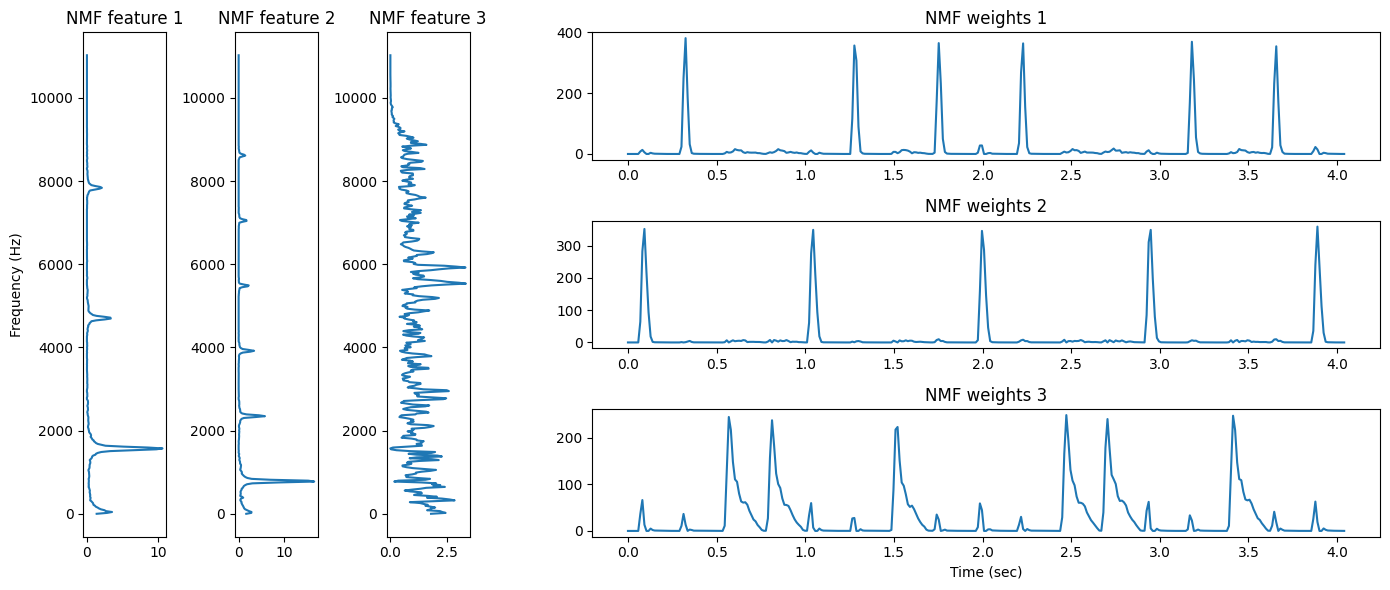

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(14, 6))

# Define subplot positions and create axes for each subplot
ax1 = plt.subplot2grid((1, 9), (0, 0))
ax2 = plt.subplot2grid((1, 9), (0, 1))
ax3 = plt.subplot2grid((1, 9), (0, 2))

ax4 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax5 = plt.subplot2grid((3, 3), (1, 1), colspan=2)
ax6 = plt.subplot2grid((3, 3), (2, 1), colspan=2)

# Plot your data and set titles, labels, etc.
ax1.plot(nmf_features[:,0], sample_frequencies)
ax1.set_title('NMF feature 1')
ax1.set_ylabel('Frequency (Hz)')

ax2.plot(nmf_features[:,1], sample_frequencies)
ax2.set_title('NMF feature 2')

ax3.plot(nmf_features[:,2], sample_frequencies)
ax3.set_title('NMF feature 3')

ax4.plot(segment_times, nmf_weights[0])
ax4.set_title('NMF weights 1')

ax5.plot(segment_times, nmf_weights[1])
ax5.set_title('NMF weights 2')

ax6.plot(segment_times, nmf_weights[2])
ax6.set_title('NMF weights 3')
ax6.set_xlabel('Time (sec)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


**Observation**: The NMF features are similar to the ICA features except we don’t see the sign-inversions here that we had in ICA because of the non-negativity constraint. As a result, we achieve an intuitive breakdown of the data, revealing the spectral and temporal characteristics of the three instruments.

# Handwritten Digit Features

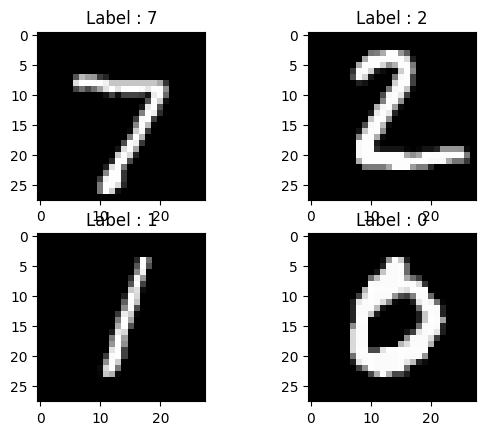

In [ ]:
# Load the data
data_path = directory+'digits-labels.npz'
data = np.load(data_path)
labels = data['l']
digits = data['d']


def show_digit(img):
    plt.imshow(img.reshape((28, 28), order='F'), cmap='gray')

for i in range(4):
    subplot(2,2, i+1),show_digit(digits[:, i]), title(f"Label : {labels[i]}")


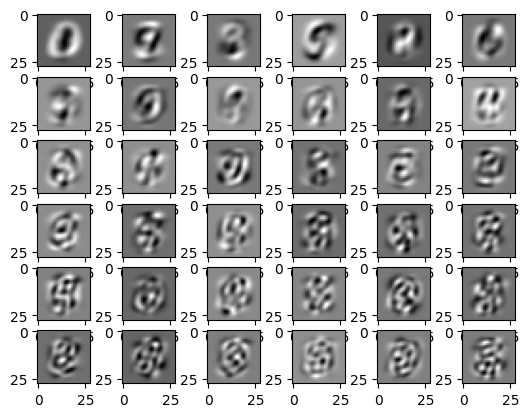

In [ ]:
num_eigen = 36
img_pca_features, img_pca_weights = pca(digits, num_eigen)
for i in range(36):
  subplot(6, 6, i+1), show_digit(img_pca_features[i])

**Observation**: We observe faint, ethereal images that retain much of the frequency content from the input images. Starting with the upper-left component, which represents the average of all inputs, we progress to less significant components where higher-frequency features emerge. Notably, these higher-frequency elements only manifest where digits are typically present, avoiding the edges of the image. First 12 components shows something similar to digits, rest of them are just mashup and not really much different from each other to make sense.

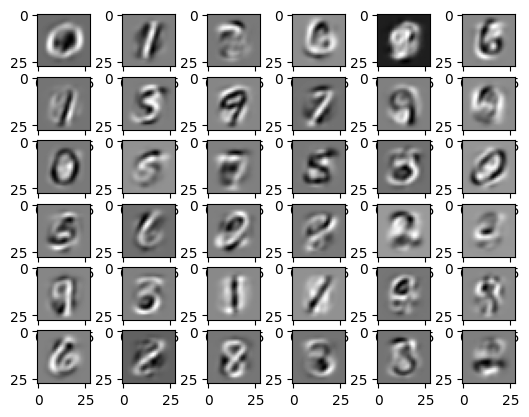

In [ ]:
#ICA on PCA output
img_ica_features, img_ica_weights = ica(img_pca_weights, num_eigen)

# Get the inverse of the overall transformation (PCA & ICA)
a = np.linalg.pinv(img_ica_features @ img_pca_features)

for i in range(36):
    subplot(6, 6, i+1), show_digit(a[:,i])

**Observation**: ICA features looks more like the actual independent digits in the input data with some mixtures.



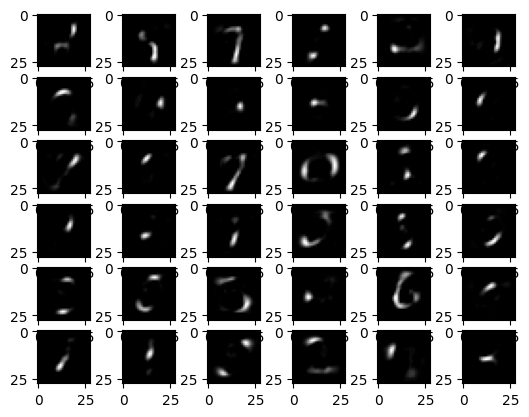

In [ ]:
# Do NMF on the original input data
img_nmf_features, img_nmf_weights = nmf(digits, num_eigen)

for i in range(36):
    subplot(6, 6, i+1), show_digit(img_nmf_features[:,i])

**Observation**: The NMF features are much different from the other two. They concentrate on specific elements of the characters, such as individual strokes, curves, or segments. NMF employs a representation strategy in which the features exhibit minimal overlap with one another.


# The geometry of handwritten digits

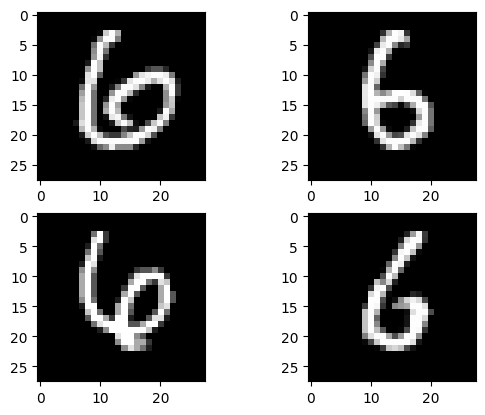

In [ ]:
digit_6 = digits[:,labels==6]

for i in range(4):
    subplot(2,2, i+1),show_digit(digit_6[:, i])


In [ ]:
img_6_features, img_6_weights = pca(digit_6, 2)


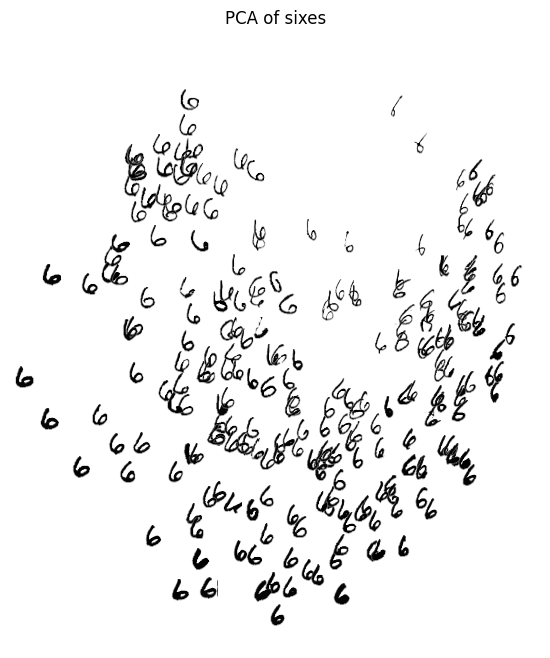

In [ ]:
def plot_digit_scatter(digits, embedding, sample_step=4):
    # Create a grayscale colormap with white transparency
    gray_alpha_colormap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'Grayscale_Alpha', [(1, 1, 1, 0), (0, 0, 0, 1)], N=128)

    # Visualize the digits within the embedding space
    plt.figure(figsize=(8, 8))
    size = np.array([(embedding[0].max() - embedding[0].min()), (embedding[1].max() - embedding[1].min())]) / 20

    for i in range(0, digits.shape[1], sample_step):
        plt.imshow(
            digits[:, i].reshape((28, 28), order='F'),
            cmap=gray_alpha_colormap,
            zorder=0,
            extent=[embedding[0, i], embedding[0, i] + size[0], embedding[1, i], embedding[1, i] + size[1]]
        )

    plt.axis([
        embedding[0].min(),
        embedding[0].max() + size[0],
        embedding[1].min(),
        embedding[1].max() + size[1]
    ])
    plt.axis('off')

plot_digit_scatter(digit_6, img_6_weights)
title( 'PCA of sixes');

**Observation**: When we visualize the data projection using the principal components, we observe a U-shaped arrangement. This arrangement captures the primary variation among these digits; it exhibits a circular wrapping, even though the variation occurs along a single axis. It is because PCA aims to produce an output with unit covariance and, being a linear transformation, it lacks the capability to untangle this variation as a one-dimensional change.
At one end of this U, we find the digit "six" instances are oriented upwards, while gradually, this trend shifts as we move towards the other end of the U, where the six have their top parts leaning to the right.

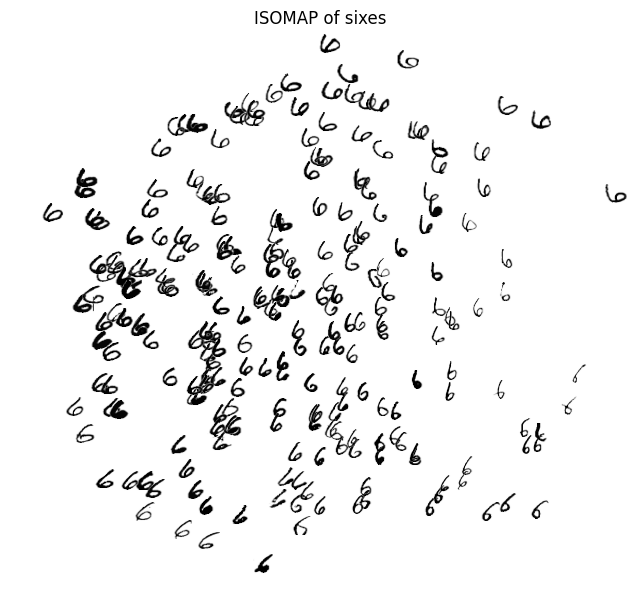

In [ ]:
# ISOMAP is a little more tricky to implement. Start by implementing MDS,
# make sure it works as expected, and then incorporate geodesic distances. You
# can use Floyd’s algorithm to get these from the the neighbor graph.

import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform

def isomap(x, n, k):
    # Compute pairwise distances
    pairwise_distances = squareform(pdist(x.T))

    # Keep only the k nearest neighbors
    sorted_indices = np.argsort(pairwise_distances, axis=1)
    for i in range(pairwise_distances.shape[0]):
        pairwise_distances[i, sorted_indices[i, k+1:]] = np.inf

    pairwise_distances = np.minimum(pairwise_distances, pairwise_distances.T)

    # Apply Floyd's algorithm for geodesic distances
    for i in range(pairwise_distances.shape[0]):
        pairwise_distances = np.minimum(pairwise_distances, pairwise_distances[:, i][:, np.newaxis] + pairwise_distances[i, :][np.newaxis, :])

    # Square and center the distances
    pairwise_distances = pairwise_distances ** 2
    pairwise_distances = -0.5 * (pairwise_distances - np.mean(pairwise_distances, axis=1, keepdims=True) - np.mean(pairwise_distances, axis=0, keepdims=True) + np.mean(pairwise_distances))

    # Compute eigenvectors
    eigenvalues, eigenvectors = eigsh(pairwise_distances, k=n)
    return eigenvectors.T


NEAREST_NEIGHS = 6
DIMS = 2
weights6 = isomap(digit_6, n=DIMS, k=NEAREST_NEIGHS)
plot_digit_scatter(digit_6, weights6)
title('ISOMAP of sixes');

**Observation**: When we do this unfolding using ISOMAP and geodesic distances, we get a clearer picture of how the number sixes are arranged. Imagine it like this: the up-and-down direction shows us how the tops of the sixes point, i.e., straigt up or bent towards right, and the other side-to-side direction tells us how thick/thin the lines of the sixes are. These representations are more straightforward compared to what we saw in PCA.